## Imports and installs

In [1]:
#for ml
import os
import torch

#for audio
import librosa
import torchaudio


os.environ['KERAS_BACKEND']='torch'

import keras


## Create dataset

In [2]:
import pandas as pd
data = pd.read_csv('adc_speakers_rough.csv')

In [3]:
labeldict = {index: element for index, element in enumerate(data['label'].unique())}

def id2label(vec):
    for i in range(len(labeldict)):
        if labeldict[i]==vec:
            if os.environ['KERAS_BACKEND']=='torch':
                return torch.Tensor([i])            
            else:
                return tf.convert_to_tensor([i])

id2label('00-felipe')

tensor([0.])

In [4]:
#using pytorch Dataset and Dataloader

from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,path,label):
        self.path = path
        self.label = label
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,index):
        audio_path = self.path[index]
        speech,sample_rate = librosa.load(audio_path)
        resampler = torchaudio.transforms.Resample(orig_freq = sample_rate)
        speech = resampler.forward(torch.Tensor(speech))
        sample_rate = 16000
        label = id2label(self.label[index])

        return audio_path,speech,sample_rate,label


In [5]:
BATCH_SIZE = 4

In [6]:
#split train and test

import numpy as np


percent = 0.8

shuffled_indices = np.random.permutation(len(data))

split = int(percent*len(data))

print(split)

train_indices = shuffled_indices[:split]
val_indices = shuffled_indices[split:]

data_train = data.iloc[train_indices].reset_index(drop=True)
data_val = data.iloc[val_indices].reset_index(drop=True)


train_dataset = AudioDataset(data_train['path'],data_train['label'])
val_dataset = AudioDataset(data_val['path'],data_val['label'])

1031


In [7]:
from torch.nn.functional import pad

def collate_fn(batch):
    #print(batch)
    path, waveforms, sample_rates, label = zip(*batch)
    # Calculate the maximum length within this batch
    max_length = max(len(waveform) for waveform in waveforms)
    #print(f'max_length = {max_length}')
    # Pad all sequences to match the maximum length
    padded_waveforms = torch.stack([pad(waveform,(0, max_length - len(waveform)), mode='constant', value=0) for waveform in waveforms])
    
    #print(f'length of the largest audio: {len(padded_waveforms[0])}')
    
    return padded_waveforms,torch.stack(label)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [8]:
from torch.nn.functional import pad

def collate_fn(batch):
    #print(batch)
    path, waveforms, sample_rates, label = zip(*batch)
    # Calculate the maximum length within this batch
    max_length = max(len(waveform) for waveform in waveforms)
    #print(f'max_length = {max_length}')
    # Pad all sequences to match the maximum length
    padded_waveforms = torch.stack([pad(waveform,(0, max_length - len(waveform)), mode='constant', value=0) for waveform in waveforms])
    
    #print(f'length of the largest audio: {len(padded_waveforms[0])}')
    
    return padded_waveforms,torch.stack(label)



In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


for batch_idx, (audio_batch, label_batch) in enumerate(train_dataloader):
    print(f"Batch #{batch_idx}")
    print(f"\tAudio batch:\n{audio_batch}\n")
    print(f"\tLabel batch:\n{label_batch}\n")
    break

Batch #0
	Audio batch:
tensor([[ 1.3884e-07, -3.6986e-08, -1.5259e-08,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.9440e-07, -1.4212e-06,  1.7923e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.9440e-07, -1.4212e-06,  1.7923e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.5030e-03, -2.2958e-03, -1.7408e-03,  ..., -1.3763e-04,
         -7.8956e-04, -4.8413e-04]])

	Label batch:
tensor([[0.],
        [3.],
        [3.],
        [4.]])



## Create model

In [10]:
layers_num = 4

inputs = keras.Input(shape=(None,1))
x = keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
for i in range(layers_num):
    x = keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
x = keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(rate=0.5)(x)
outputs = keras.layers.Dense(5,'softmax')(x)

model2 = keras.Model(inputs=inputs,outputs=outputs)

model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 1)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d (Conv1D)                 │ (None, None, 64)          │        256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_4 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_4           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_5 (Conv1D)               │ (None, None, 128)         │     24,704 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_5           │ (None, None, 128)         │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d        │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼──────────

 Total params: 93,317 (364.52 KB)

 Trainable params: 92,421 (361.02 KB)

 Non-trainable params: 896 (3.50 KB)

In [11]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model2.fit(train_dataloader,
                     validation_data=val_dataloader,
                     epochs=10,
                     batch_size=BATCH_SIZE)

Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 890s 3s/step - accuracy: 0.4630 - loss: 1.2804 - val_accuracy: 0.2054 - val_loss: 4.7183
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.6875 - loss: 0.8132 - val_accuracy: 0.2713 - val_loss: 2.2372
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 709s 3s/step - accuracy: 0.7270 - loss: 0.7120 - val_accuracy: 0.4457 - val_loss: 3.3129
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 709s 3s/step - accuracy: 0.7710 - loss: 0.6019 - val_accuracy: 0.1628 - val_loss: 12.7601
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 710s 3s/step - accuracy: 0.7657 - loss: 0.6564 - val_accuracy: 0.8295 - val_loss: 0.6162
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 760s 3s/step - accuracy: 0.7862 - loss: 0.5676 - val_accuracy: 0.1628 - val_loss: 13.0767
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 801s 3s/step - accuracy: 0.7597 - loss: 0.6055 - val_accuracy: 0.4225 - val_loss: 1.2523
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 829s 3s/step - accuracy: 0.8337 - loss: 0.4725 - val_ac

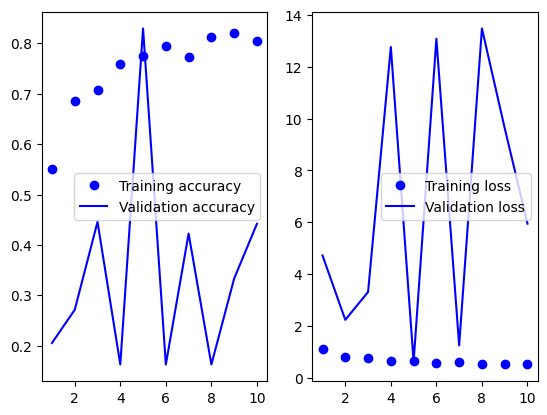

In [12]:
import matplotlib.pyplot as plt 
accuracy = history.history["accuracy"] 
val_accuracy = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 

epochs = range(1, len(accuracy) + 1) 

plt.subplot(121)
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.legend()


## Save model

In [14]:
model2.save('model_raw.keras')

In [15]:
testmodel = keras.saving.load_model('model_raw.keras', custom_objects=None, compile=True, safe_mode=True)

testmodel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 1)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d (Conv1D)                 │ (None, None, 64)          │        256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_4 (Conv1D)               │ (None, None, 64)          │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_4           │ (None, None, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, None, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_5 (Conv1D)               │ (None, None, 128)         │     24,704 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_5           │ (None, None, 128)         │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d        │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼──────────

 Total params: 278,161 (1.06 MB)

 Trainable params: 92,421 (361.02 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 184,844 (722.05 KB)

In [16]:
testmodel.evaluate(val_dataloader)

65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4045 - loss: 5.9969


[6.366375923156738, 0.42248061299324036]